In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
from PIL import Image
import random
import cv2 as cv
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(42)
torch.manual_seed(42)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
train_path = "seg_train/"
test_path = "seg_test/"

In [4]:
train_classes = sorted(os.listdir(train_path))

label_map = {i: name for i, name in enumerate(train_classes)}

print(label_map)

{0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}


#### Visualising Images

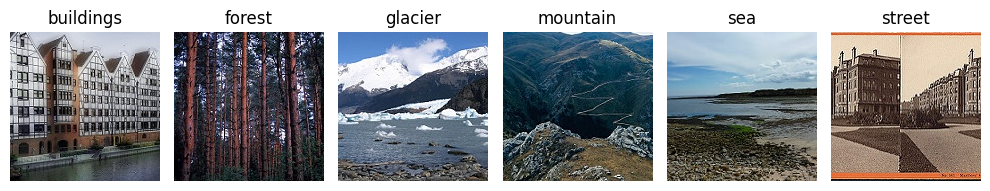

In [5]:
fig, ax = plt.subplots(1, len(train_classes), figsize=(10, 10))

for idx,i in enumerate(train_classes):
    path = os.path.join(train_path, i)
    image = random.choice(os.listdir(path))
    img = os.path.join(path, image)
    img = cv.imread(img)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    ax[idx].imshow(img)
    ax[idx].set_title(i)
    ax[idx].axis('off') 

plt.tight_layout()
plt.show()

#### Preprocessing the Data

In [6]:
transform = transforms.Compose([
    transforms.Resize((227, 227), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform = transform):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.images = []
        self.labels = []

        for idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for image_name in os.listdir(class_dir):
                self.images.append(os.path.join(class_dir, image_name))
                self.labels.append(idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]


        if self.transform:
            image = self.transform(image)

        return image, label


train_dataset = CustomDataset(root_dir = train_path, transform = transform)
test_dataset = CustomDataset(root_dir = test_path, transform = transform)

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

#### Building Alexnet Architecture

In [9]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2),
            nn.Conv2d(96, 256, kernel_size=5,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3,2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 6)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [10]:
model = AlexNet().to(device)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [12]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, 

#### Training the Model

In [13]:
num_epochs = 10
accuracy = []
losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        
    train_accuracy = 100*correct_train/total_train
    accuracy.append(train_accuracy)
    train_loss = running_loss / len(train_dataloader.dataset)
    losses.append(train_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}')

Epoch 1/10, Loss: 1.0244, Accuracy: 58.72
Epoch 2/10, Loss: 0.6869, Accuracy: 75.00
Epoch 3/10, Loss: 0.5456, Accuracy: 80.44
Epoch 4/10, Loss: 0.4725, Accuracy: 83.25
Epoch 5/10, Loss: 0.4099, Accuracy: 85.71
Epoch 6/10, Loss: 0.3752, Accuracy: 86.55
Epoch 7/10, Loss: 0.3329, Accuracy: 88.04
Epoch 8/10, Loss: 0.2882, Accuracy: 89.87
Epoch 9/10, Loss: 0.2702, Accuracy: 90.22
Epoch 10/10, Loss: 0.2417, Accuracy: 91.31


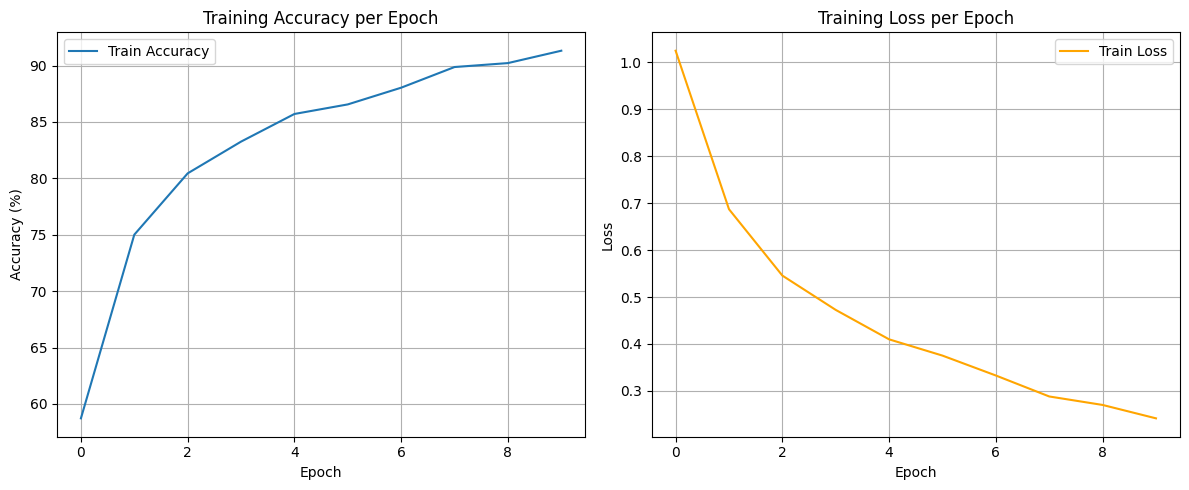

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(accuracy, label='Train Accuracy')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy (%)")
axes[0].set_title("Training Accuracy per Epoch")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(losses, label='Train Loss', color='orange')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].set_title("Training Loss per Epoch")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [22]:
model.eval()
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    test_accuracy = 100 * correct_test / total_test

print(f'Accuracy: {100 * correct_test/ total_test:.2f}%')

Accuracy: 85.13%


In [23]:
cm = confusion_matrix(all_labels, all_preds)

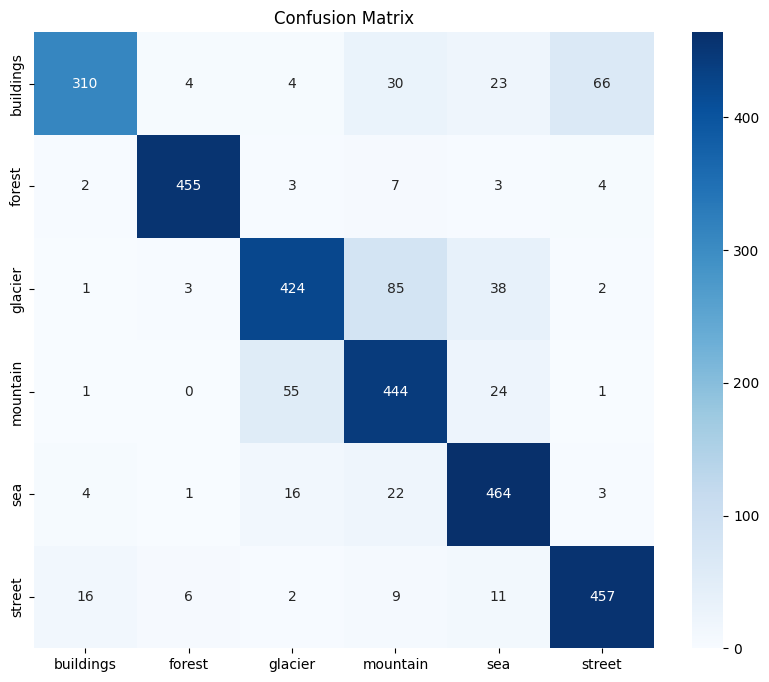

In [25]:
class_names = [label_map[i] for i in range(len(label_map))]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.show()

In [17]:
def predict_model(image_path):
    image = Image.open(image_path).convert('RGB')
    image = image.resize((227,227))
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image)
        probabilities = torch.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    return predicted.item(), confidence.item()

#### Using 10 random images and predicting their classes

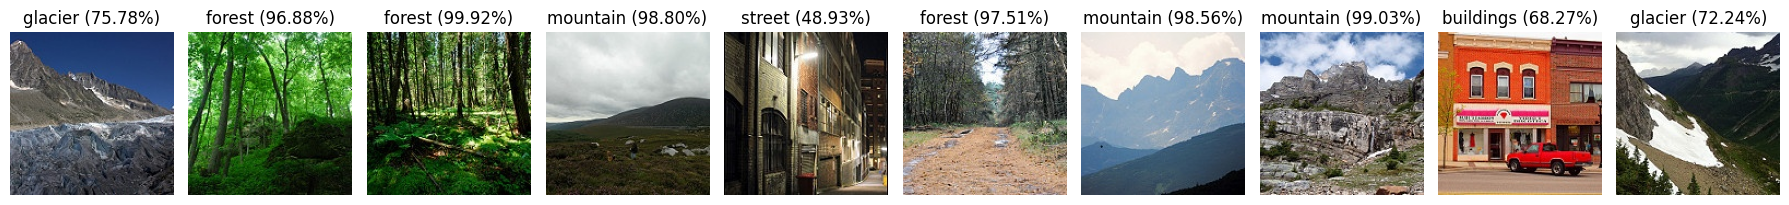

In [32]:
pred_path = 'seg_pred/'

images = random.sample(os.listdir(pred_path), 10)

plt.figure(figsize=(18, 6))

for index, img_name in enumerate(images):
    img_path = os.path.join(pred_path, img_name)
    label_index, accuracy = predict_model(img_path)
    label = label_map[label_index]

    img = Image.open(img_path)
    
    plt.subplot(1, 10, index + 1)
    plt.imshow(img)
    plt.title(f'{label} ({accuracy*100:.2f}%)')
    plt.axis('off')

plt.tight_layout()
plt.show()